# Summarising the mean and the variance using the IMNN

For this example we are going use the IMNN and the LFI module to infer the unknown mean, $\mu$, and variance, $\Sigma$, of $n_{\bf d}=10$ data points of a 1D random Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(\mu,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\mu,\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

In [1]:
import numpy as np
import tensorflow as tf
from IMNN import IMNN
from IMNN.LFI import LFI
from make_data import GenerateGaussianNoise
from make_data import AnalyticLikelihood
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions

print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__))

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


IMNN 0.2dev
TensorFlow 2.3.0
TensorFlow Probability 0.11.0
numpy 1.18.5


The objective is to use neural networks to fit the function that optimally extracts information from data about parameters of interest.

The neural network takes some data ${\bf d}$ and maps it to a compressed summary $\mathscr{f}:{\bf d}\to{\bf x}$ where ${\bf x}$ can have the same size as the dimensionality of the parameter space, rather than the data space, potentially without losing any information. To do so we maximise the Fisher information of the summary statistics provided by the neural network, and in doing so, find a functional form of the optimal compression.

To train the neural network a batch of simulations ${\bf d}_{\sf sim}^{\sf fid}$ created at a fiducial parameter value $\boldsymbol{\theta}^{\rm fid}$ for training (and another for validation). These simulations are compressed by the neural network to obtain some statistic ${\bf x}_{\sf sim}^{\sf fid}$, i.e. the output of the neural network. We can use these to calculate the covariance ${\bf C_\mathscr{f}}$ of the compressed summaries. The sensitivity to model parameters uses the derivative of the simulation. This can be provided analytically or numercially using ${\bf d}_{\sf sim}^{\sf fid+}$ created above the fiducial parameter value $\boldsymbol{\theta}^{\sf fid+}$ and ${\bf d}_{\sf sim}^{\sf fid-}$ created below the fiducial parameter value $\boldsymbol{\theta}^{\sf fid-}$. The simulations are compressed using the network and used to find mean of the summaries 
$$\frac{\partial\boldsymbol{\mu}_\mathscr{f}}{\partial\theta_\alpha}=\frac{1}{n_\textrm{derivs}}\sum_{i=1}^{n_\textrm{derivs}}\frac{{\bf x}_{\sf sim}^{\sf fid+}-{\bf x}_{\sf sim}^{\sf fid-}}{\boldsymbol{\theta}^{\sf fid+}-\boldsymbol{\theta}^{\sf fid-}}.$$
If the derivative of the simulations with respect to the parameters can be calculated analytically (or via autograd, etc.) then that can be used directly using the chain rule since the derivative of the network outputs with respect to the network input can be calculated easily
$$\frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha} = \frac{1}{n_{\textrm{sims}}}\sum_{i=1}^{n_{\textrm{sims}}}\frac{\partial{\bf x}_i}{\partial{\bf d}_j}\frac{\partial{\bf d}_j}{\partial\theta_\alpha}\delta_{ij}.$$
We then use ${\bf C}_\mathscr{f}$ and $\boldsymbol{\mu}_\mathscr{f},_\alpha$ to calculate the Fisher information
$${\bf F}_{\alpha\beta} = \boldsymbol{\mu}_\mathscr{f},^T_{\alpha}{\bf C}^{-1}_\mathscr{f}\boldsymbol{\mu}_\mathscr{f},_{\beta}.$$
Since any linear rescaling of the summaries is also a summary, when maximising the Fisher information we set their scale using
    $$\Lambda = -\ln|{\bf F}_{\alpha\beta}|+r(\Lambda_2)\Lambda_2$$
where 
    $$\Lambda_2 = ||{\bf C}_\mathscr{f}-\mathbb{1}||_2 + ||{\bf C}_\mathscr{f}^{-1}-\mathbb{1}||_2$$
is a regularisation term whose strength is dictated by 
    $$r(\Lambda_2) = \frac{\lambda\Lambda_2}{\Lambda_2 + \exp(-\alpha\Lambda_2)}$$
with $\lambda$ as a strength and $\alpha$ as a rate parameter which can be determined from a closeness condition on the Frobenius norm of the difference between the convariance (and inverse covariance) from the identity matrix.

### Generate data

For the mean and variance problem described above we can generate the training and validation data using the premade module `GenerateGaussianNoise`. Our fiducial set will be created with model parameters $\mu=0$ and $\Sigma=1$. In this example we use 1000 simulations for the fiducial training set (with $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$), 1000 simulations for the fiducial validation set (also with $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$), and we will use numerical derivatives with 1000 simulations for each parameter in each direction (1000 simulations at $\mu^-=-0.1$ and $\Sigma^\textrm{fid}=1$, 1000 simulations at $\mu^+=0.1$ and $\Sigma^\textrm{fid}=1$, 1000 simulations at $\mu^\textrm{fid}=0$ and $\Sigma^-=0.9$ and 1000 simulations at $\mu^\textrm{fid}=0$ and $\Sigma^{+}=1.1$. Obviously, we'll need a set of derivative simulations for the validation set too. There will be sensitivity in fitting the network dependent on how well the numerical derivatives are performed (how far apart the $\delta\theta$). Note that for the numerical derivatives it is best to use seed matched simulations, i.e. if there are 1000 simulations for each derivative, then the first simulation for each derivative of those 1000 would all have the same seed, only varying by parameter value. The second simulation for each derivative would all have the same seed, differing from the first, and so on. This increases stability and can massively reduce the number of simulations needed (by orders of magnitude in principle).

In this example, we will store the training data as a tensor (which would be stored on the GPU if it is being used). This is extremely fast, but won't work for large simulation sizes - for this see either the tutorial `IMNN - function loading.ipynb` or `IMNN - TFRecords.ipynb`. The details are available as a dictionary and as module attributes.

In [2]:
GN = GenerateGaussianNoise()
details, fiducial, validation_fiducial, derivative, validation_derivative = GN.generate_data()

In [3]:
print("fiducial = {}\nvalidation_fiducial = {}\nderivative = {}\nvalidation_derivative = {}".format(
    fiducial.shape, validation_fiducial.shape, derivative.shape, validation_derivative.shape))

fiducial = (1000, 10)
validation_fiducial = (1000, 10)
derivative = (1000, 2, 2, 10)
validation_derivative = (1000, 2, 2, 10)


The numerical derivatives (when loaded as a numpy array) must have the same `(seed, derivative, parameters) + input_shape` where `derivative[:, 0, ...]` contains the lower derivative for each parameter and `derivative[:, 1, ...]` contains the upper derivative for each parameter.

### Setup network

The IMNN is built around a keras(-like) model and optimiser for simplicity, which takes in the data and compresses (sensibly) down to as few as the number of parameters in the model. Here we will use a fully connected network with two layers and 128 neurons in each and using `leaky relu` for activation. We will also use the `Adam` optimiser.

In [4]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=GN.input_shape),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(GN.n_summaries),
    ])
opt = tf.keras.optimizers.Adam()

### Initialise the IMNN

The IMNN needs a bunch of details about the number of simulations used for training, the number of parameters, the number of summaries, the neural network and the optimiser, the fiducial parameters and numerical derivative parameter differences as well as the data to fit the summarising function. If all the data fits into memory at once then we can set `at_once=GN.n_s` which will process all the data at once. We can save the neural network by setting `save=True` and passing a directory and filename to save to. Here we will save the network in a directory called `model` (and called `model`).

In [5]:
imnn = IMNN.IMNN(n_s=GN.n_s, n_d=GN.n_d, n_params=GN.n_params, n_summaries=GN.n_summaries,
                 model=model, optimiser=opt, θ_fid=GN.θ_fid, δθ=GN.δθ, input_shape=GN.input_shape,
                 fiducial=fiducial, derivative=derivative, validation_fiducial=validation_fiducial,
                 validation_derivative=validation_derivative, at_once=GN.n_s,
                 check_shape=True, verbose=True, directory="model", filename="model", save=True, build=True)

input shape will be (10,)
saving model to model/model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/model/assets


We can train the IMNN by running `fit`. This can be done for `n_iterations` number of iterations or run with stopping (which is preferred to make sure that saturation of the Fisher information happens. For stopping, we can set a `patience` and `min_iterations` to prevent any initial settling of the fitting procedure. Checkpointing can be done every `x` epochs by setting `checkpoint=x`, and the weights can be save to a file `filename` using `weight_file=filename`.

In [6]:
imnn.fit(patience=10, min_iterations=1000)

Using patience length of 10. Maximum number of training iterations is 10000000000.
Saving current model in model/model


Reached 10 steps without increasing val_det_F. Resetting weights to iteration 8990.



A history (imnn.history) dictionary is collecting diagnostics. It contains
- `det_F` : determinant of the Fisher information
- `det_C` : determinant of the covariance of the summaries
- `det_Cinv` : determinant of the inverse covariance of the summaries
- `det_dμ_dθ` : derivative of the mean of the summaries with respect to the parameters
- `reg` : value of the regulariser
- `r` : value of the regulariser strength

and the same for the validation set

- `val_det_F` : determinant of the Fisher information for the validation set
- `val_det_C` : determinant of the covariance of the summaries from the validation set
- `val_det_Cinv` : determinant of the inverse covariance of the summaries from the validation set
- `val_det_dμ_dθ` : derivative of the mean of the summaries from the validation set with respect to the parameters

which can be plotted using

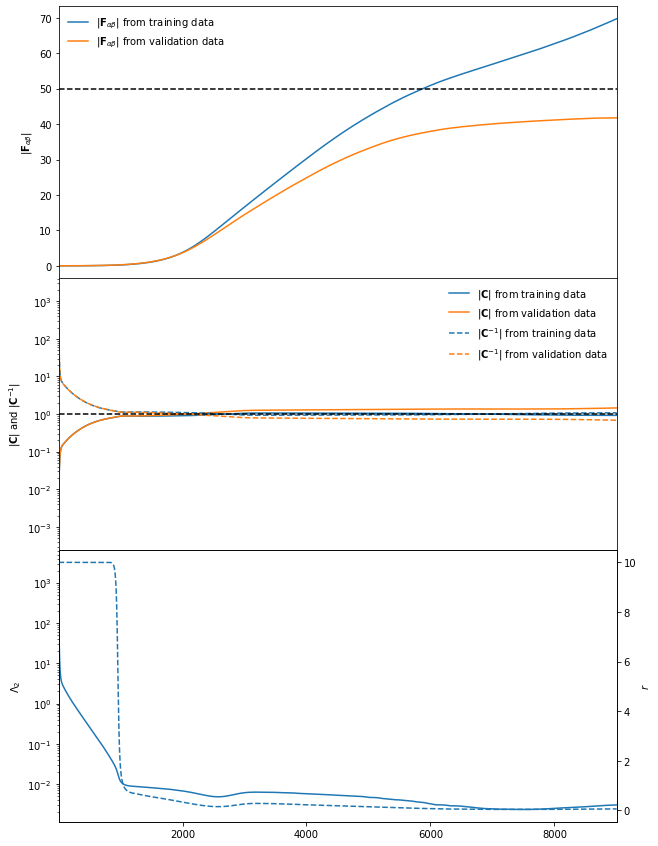

In [7]:
imnn.plot(known_det_fisher=50)

Note that when initialising the IMNN, `imnn = IMNN.IMNN(...)`, once training has completed we can also load a model by setting `load=True` and passing a `filename` and `directory` which contains the model. In this case, `model=None` and `optimiser=None` can be set. Note that optimisers with a state should be loaded externally - loading keras models might be easier to do externally too. Once the network is fit it is not actually necessary to reload the IMNN module though, the model can be used directly for likelihood-free inference by defining an estimator like `imnn.get_MLE(data)` which we can recover from a saved IMNN instance using
```python
estimator_parameters = np.load("model/model/estimator.npz")
Finv = estimator_parameters["Finv"]
θ_fid = estimator_parameters["θ_fid"]
dμ_dθ = estimator_parameters["dμ_dθ"]
Cinv = estimator_parameters["Cinv"]
μ = estimator_parameters["μ"]

@tf.function
def estimator(data):
    return tf.add(
        θ_fid,
        tf.einsum(
            "ij,jk,kl,ml->mi", 
            Finv, 
            dμ_dθ, 
            Cinv,
            model(data) - μ))
```
or a numpy-like alternative.

## Inferring the mean and variance
Lets observe some data generated from a Gaussian distribution with a mean, $\mu=0$, and a variance $\Sigma=1$ - we're going to generate the data from seed 37 (for no particular reason). Once this is generated we're going to forget that we ever knew this. Simulations from this model can be made using

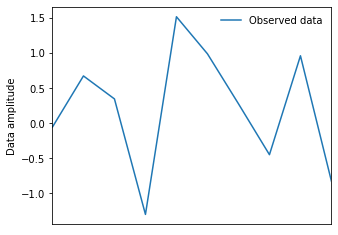

In [8]:
generator = GenerateGaussianNoise()

θ_target = np.array([0., 1,])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

For the inference we start by defining our prior as a uniform distribution. This distribution can be a TensorFlow Probability distribution for simplicity. We are going to choose the prior to be uniform from -10 to 10 for the mean and 0 to 10 for the variance.

$$p(\mu,\Sigma)=\textrm{Uniform}\left[\textrm{lower}=(-10, 0),\textrm{upper}=(10,10)\right]$$

In [9]:
prior = tfd.Blockwise([tfd.Uniform(-10., 10.),
                       tfd.Uniform(0.1, 10.)])

In the `AnalyticLikelihood` module we have routines for calculating the exact likelihood for this problem.

In [10]:
AL = AnalyticLikelihood(
    parameters=2,
    data=target_data, 
    prior=prior, 
    generator=generator,
    labels=[r"$\mu$", r"$\Sigma$"])

### Gaussian approximation to the posterior

We can compare an estimate of the mean and variance of the target data from the network with the exact values - note it is not necessary for these to coincide particularly well

In [11]:
print("Mean and variance of observed data = {}\nNetwork estimate of observed data = {}".format(
    AL.get_estimate(target_data), imnn.get_estimate(target_data.astype(np.float32))))

Mean and variance of observed data = [[0.214 0.699]]
Network estimate of observed data = [[0.165 0.715]]


Now we can use the IMNN to try and infer the parameters of the model given the observations, i.e. the mean and variance of the target data. A more in depth overview of the LFI module is provided in `examples`.

In [12]:
GA = LFI.GaussianApproximation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    labels=[r"$\mu$", r"$\Sigma$"])

The inverse Fisher information describes the Cramer-Rao bound, i.e. the minimum variance of a Gaussian approximation of the likelihood about the fiducial parameter values. We can therefore use the Fisher information to make an approximation to posterior. The inverse Fisher can be viewed using

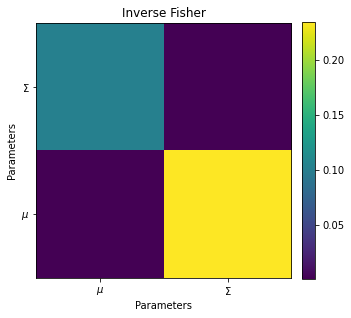

In [13]:
GA.plot_Fisher(figsize=(5, 5));

And the Gaussian approximation to the posterior given by

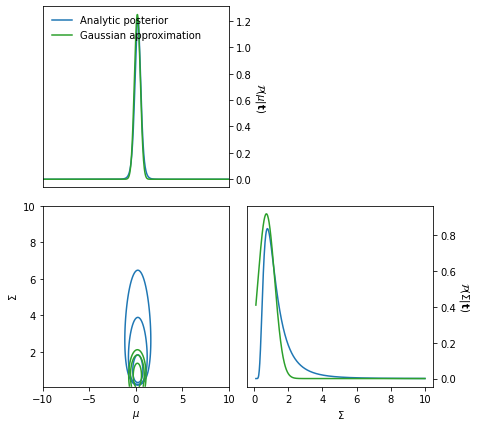

In [14]:
ax = AL.plot(
    gridsize=(1000, 1000),
    figsize=(7, 7),
    color="C0", 
    label="Analytic posterior");
GA.plot(
    gridsize=(1000, 1000),
    ax=ax,
    color="C2",
    label="Gaussian approximation");

## Approximate Bayesian computation
We can also do approximate Bayesian computation using the IMNN outputs as sufficient statistics describing the data. The ABC draws parameter values from the prior and makes simulations at these points. These simulations are then summarised, i.e. we find the mean and variance of the simulations in this case, and then the distance between these estimates and the estimate of the target data can be calculated. Estimates within some small ϵ-ball around the target estimate are approximately samples from the posterior. Note that the larger the value of ϵ, the worse the approximation to the posterior. 

In [15]:
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=GN.simulator,
    labels=[r"$\mu$", r"$\Sigma$"])

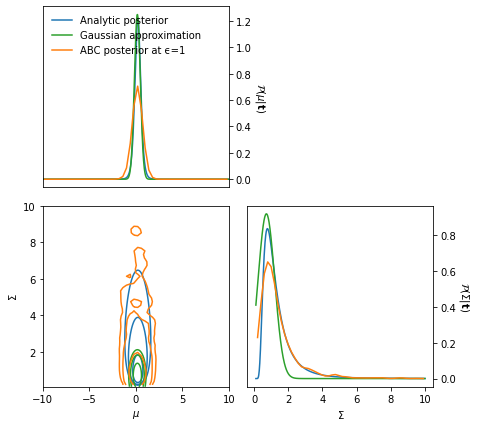

In [16]:
ax = AL.plot(
    gridsize=(1000, 1000),
    figsize=(7, 7),
    color="C0", 
    label="Analytic posterior");
GA.plot(
    gridsize=(1000, 1000),
    ax=ax,
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ϵ=1.,
    accepted=2000,
    draws=10000,
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(1),
    smoothing=1,
    bins=50);

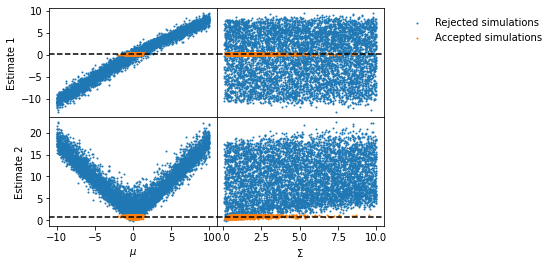

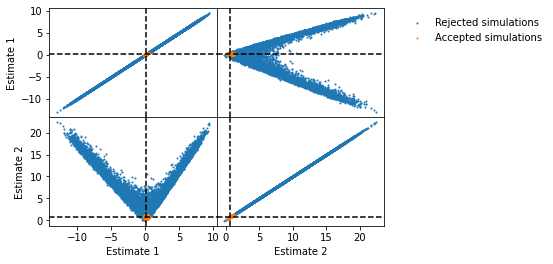

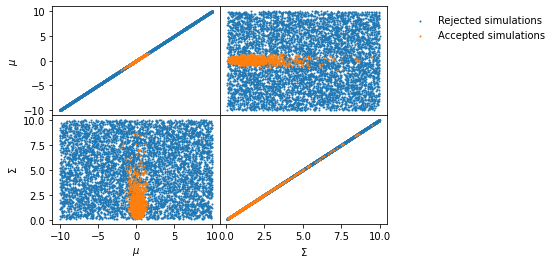

In [17]:
ABC.scatter_plot(axes="parameter_estimate", rejected=0.01);
ABC.scatter_plot(axes="estimate_estimate", rejected=0.01);
ABC.scatter_plot(axes="parameter_parameter", rejected=0.01);

## Population Monte Carlo

Whilst we can obtain approximate posteriors using ABC, the rejection rate is very high because we sample always from the prior. Population Monte Carlo (PMC) uses statistics of the population of samples to propose new parameter values, so each new simulation is more likely to be accepted. This prevents us needing to define an ϵ parameter to define the acceptance distance. Instead we start with a population from the prior and iteratively move samples inwards. Once it becomes difficult to move the population any more, i.e. the number of attempts to accept a parameter becomes very large, then the distribution is seen to be a stable approximation to the posterior.

The whole module works very similarly to `ABC` with a few changes in arguments.

In [18]:
PMC = LFI.PopulationMonteCarlo(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=GN.simulator,
    labels=[r"$\mu$", r"$\Sigma$"])

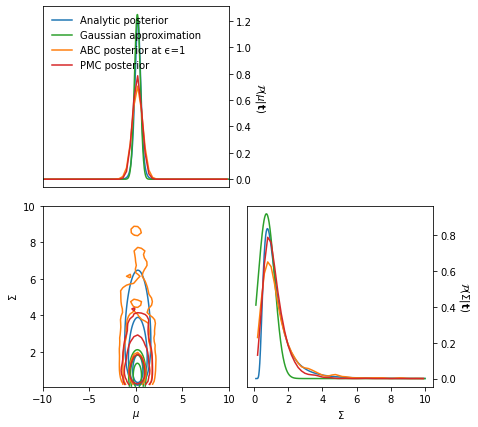

In [19]:
ax = AL.plot(
    gridsize=(1000, 1000),
    figsize=(7, 7),
    color="C0", 
    label="Analytic posterior");
GA.plot(
    gridsize=(1000, 1000),
    ax=ax,
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(1),
    smoothing=1,
    bins=50)
PMC.plot(
    draws=2000,
    initial_draws=5000,
    criterion=0.01,
    percentile=75,
    ax=ax,
    color="C3",
    label="PMC posterior",
    smoothing=1,
    bins=50);

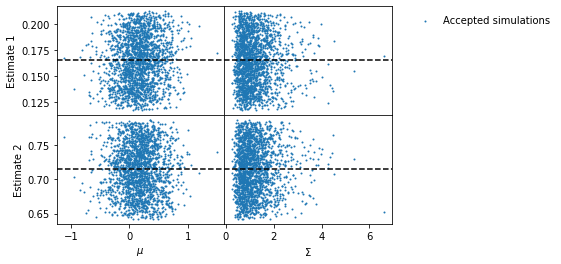

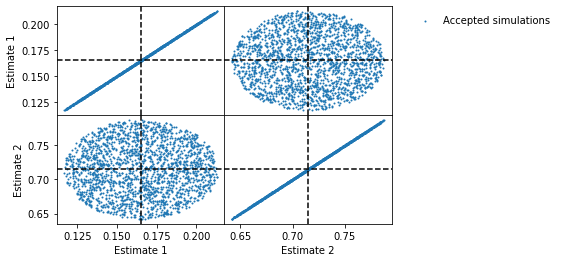

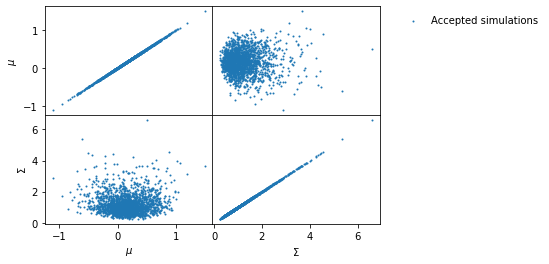

In [20]:
PMC.scatter_plot(axes="parameter_estimate")
PMC.scatter_plot(axes="estimate_estimate")
PMC.scatter_plot(axes="parameter_parameter")